In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np
import joblib

In [2]:
base_path = os.getcwd()
players_file = os.path.join(base_path, "Datos", "players_22.csv")

players = pd.read_csv(players_file, encoding="utf-8", low_memory=False)

features = ["overall", "potential", "wage_eur", "value_eur", "age"]
players = players.dropna(subset=features)
data = players[features].copy()

In [3]:
# === Escalado de datos ===
scaler = StandardScaler()
scaled_data = data

In [4]:
# === Buscar número óptimo de clusters (Elbow y Silhouette) ===
inertias = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    sil = silhouette_score(scaled_data, labels)
    sil_scores.append(sil)

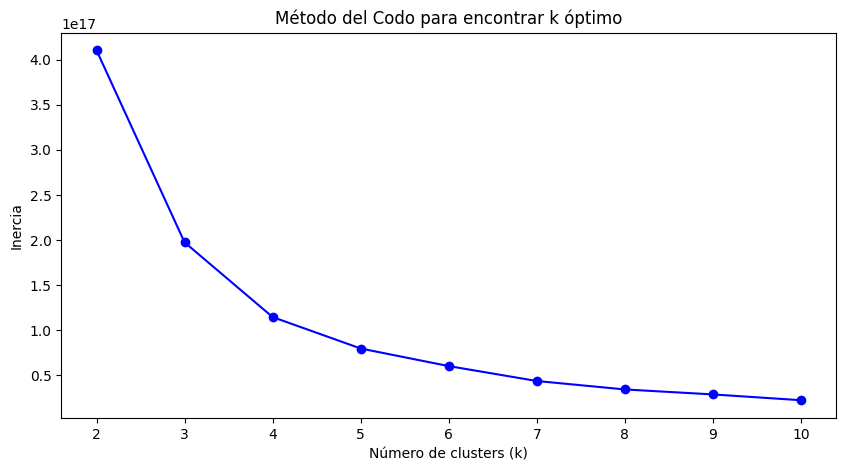

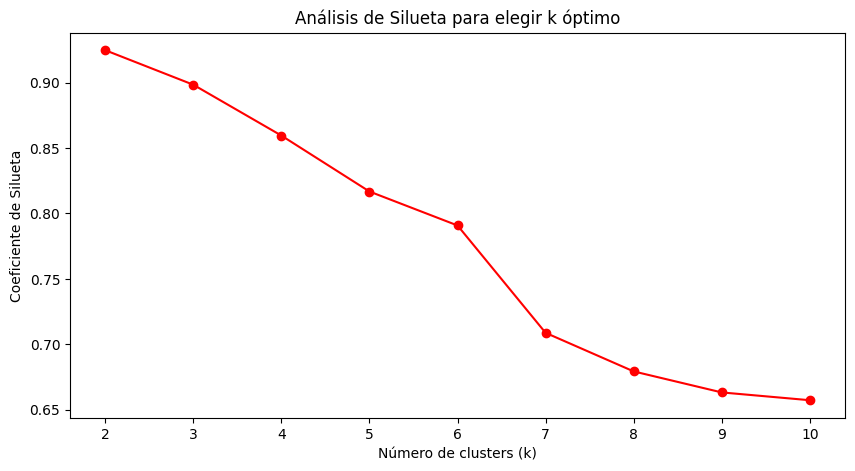


Número óptimo de clusters según Silhouette Score: 2


In [5]:
# Gráfico del método del codo
plt.figure(figsize=(10, 5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.title("Método del Codo para encontrar k óptimo")
plt.show()

# Gráfico del coeficiente de silueta
plt.figure(figsize=(10, 5))
plt.plot(k_range, sil_scores, "ro-")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Coeficiente de Silueta")
plt.title("Análisis de Silueta para elegir k óptimo")
plt.show()

# Elegir el mejor k (máximo silueta)
best_k = k_range[np.argmax(sil_scores)]
print(f"\nNúmero óptimo de clusters según Silhouette Score: {best_k}")

In [6]:
# === Entrenar modelo final ===
model = KMeans(n_clusters=best_k, random_state=42, n_init=10)
players["cluster"] = model.fit_predict(scaled_data)

# === Resumen por clúster ===
cluster_summary = (
    players.groupby("cluster")[features]
    .mean()
    .round(2)
    .assign(num_players=players["cluster"].value_counts().sort_index())
)

print("\n=== Resumen por clúster ===")
print(cluster_summary)


=== Resumen por clúster ===
         overall  potential  wage_eur    value_eur    age  num_players
cluster                                                               
0          65.37      70.75   7142.84   1928074.59  25.17        18729
1          82.33      85.25  89731.65  42472477.06  25.93          436


In [7]:
# === Calcular score de relación calidad/precio ===
scaler_minmax = MinMaxScaler()
cluster_features = cluster_summary[["potential", "overall", "value_eur", "wage_eur"]].copy()
cluster_scaled = pd.DataFrame(scaler_minmax.fit_transform(cluster_features),
                              columns=cluster_features.columns)

cluster_scaled["score"] = (
    cluster_scaled["potential"] * 0.6 +    # mucho peso al potencial
    cluster_scaled["overall"] * 0.05 -     # poco peso al rendimiento actual
    cluster_scaled["value_eur"] * 0.25 -   # penaliza el precio alto
    cluster_scaled["wage_eur"] * 0.1       # penaliza el salario alto
)

best_cluster = cluster_scaled["score"].idxmax()
jugadores_objetivo = players.loc[players["cluster"] == best_cluster]

print(f"\nClúster objetivo (mejor relación calidad/precio): {best_cluster}")


Clúster objetivo (mejor relación calidad/precio): 1


In [8]:
# Mostrar los 5 mejores clústeres según score
top_clusters = cluster_scaled.sort_values(by="score", ascending=False).head(5)
print("\n=== Top 5 clústeres según score ===")
print(top_clusters)

# Tomar los jugadores de esos 5 clústeres
jugadores_top5 = players[players["cluster"].isin(top_clusters.index)]

print("\n=== Jugadores de los 5 mejores clústeres ===")
print(jugadores_top5[["short_name", "overall", "potential", "value_eur", "wage_eur", "age"]]
      .sort_values(by="potential", ascending=False)
      .head(50))


=== Top 5 clústeres según score ===
   potential  overall  value_eur  wage_eur  score
1        1.0      1.0        1.0       1.0    0.3
0        0.0      0.0        0.0       0.0    0.0

=== Jugadores de los 5 mejores clústeres ===
               short_name  overall  potential    value_eur  wage_eur  age
6               K. Mbappé       91         95  194000000.0  230000.0   22
29             E. Haaland       88         93  137500000.0  110000.0   20
5                J. Oblak       91         93  112000000.0  130000.0   28
21          G. Donnarumma       89         93  119500000.0  110000.0   22
0                L. Messi       93         93   78000000.0  320000.0   34
43             F. de Jong       87         92  119500000.0  210000.0   24
1          R. Lewandowski       92         92  119500000.0  270000.0   32
138            K. Havertz       84         92   94500000.0  130000.0   22
139              P. Foden       84         92   94500000.0  125000.0   21
8           M. ter Stegen  


=== Jugadores del clúster objetivo ===
              short_name  overall  potential    value_eur  wage_eur  age
6              K. Mbappé       91         95  194000000.0  230000.0   22
0               L. Messi       93         93   78000000.0  320000.0   34
21         G. Donnarumma       89         93  119500000.0  110000.0   22
5               J. Oblak       91         93  112000000.0  130000.0   28
29            E. Haaland       88         93  137500000.0  110000.0   20
43            F. de Jong       87         92  119500000.0  210000.0   24
138           K. Havertz       84         92   94500000.0  130000.0   22
139             P. Foden       84         92   94500000.0  125000.0   21
1         R. Lewandowski       92         92  119500000.0  270000.0   32
8          M. ter Stegen       90         92   99000000.0  250000.0   29
44   T. Alexander-Arnold       87         92  114000000.0  150000.0   22
198           João Félix       83         91   82000000.0   61000.0   21
18         

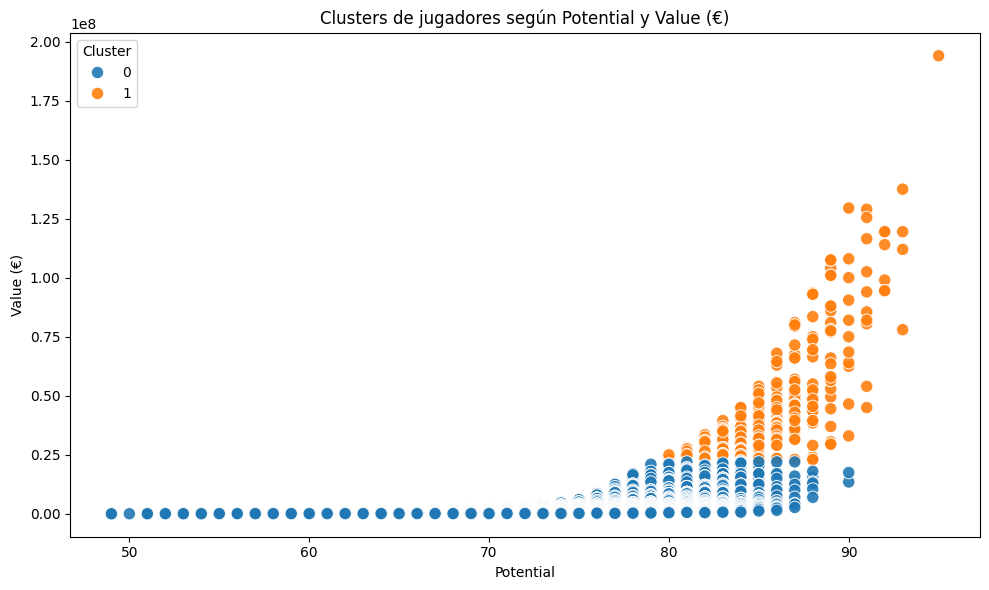

In [9]:
# === Mostrar jugadores destacados ===
top_jugadores = jugadores_objetivo[["short_name", "overall", "potential", "value_eur", "wage_eur", "age"]] \
    .sort_values(by="potential", ascending=False).head(50)

print("\n=== Jugadores del clúster objetivo ===")
print(top_jugadores)

# === Visualizaciones finales ===
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=players, x="potential", y="value_eur",
    hue="cluster", palette="tab10", alpha=0.9, s=80
)
plt.title("Clusters de jugadores según Potential y Value (€)")
plt.xlabel("Potential")
plt.ylabel("Value (€)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

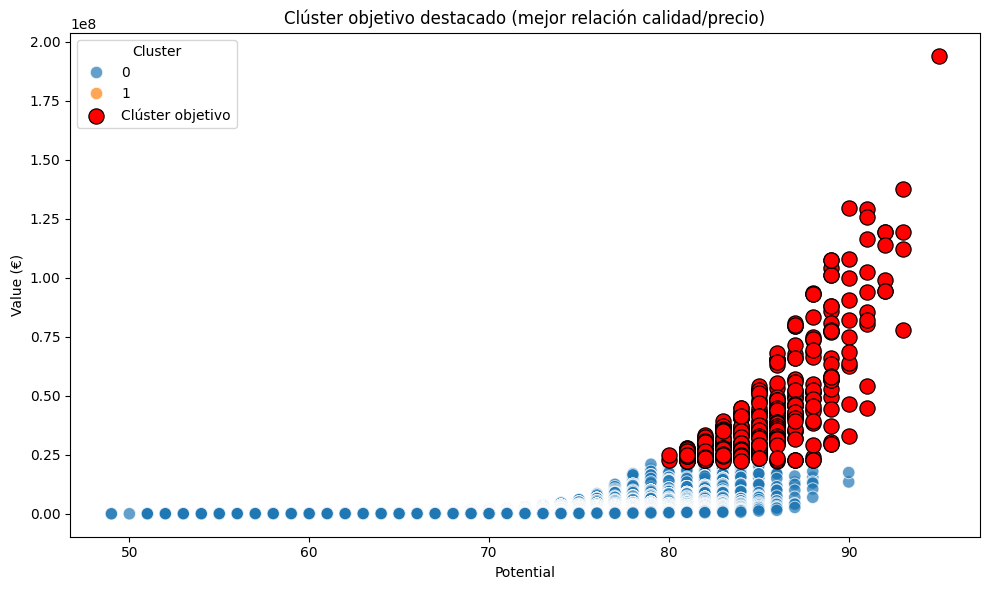

In [10]:
# Destacar el clúster objetivo
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=players, x="potential", y="value_eur",
    hue="cluster", palette="tab10", alpha=0.7, s=80
)
sns.scatterplot(
    data=jugadores_objetivo, x="potential", y="value_eur",
    color="red", s=120, label="Clúster objetivo", edgecolor="k"
)
plt.title("Clúster objetivo destacado (mejor relación calidad/precio)")
plt.xlabel("Potential")
plt.ylabel("Value (€)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()